# Stage 12 — Results, Reporting, Delivery

In [1]:
import numpy as np, pandas as pd, matplotlib.pyplot as plt
from pathlib import Path

In [2]:
p1=Path('../data/stage12_business_metrics.csv')
p2=Path('./data/stage12_business_metrics.csv')
data_path=p1 if p1.exists() else p2
df=pd.read_csv(data_path, parse_dates=['date'])
df.head()

,date,segment,visitors,conversions,conversion_rate,price,revenue,ad_spend,cogs,profit
0,2025-01-01,A,1463,68,0.046374,50,3414.140020,838.367320,1353.796815,1221.975885
1,2025-01-02,C,1308,37,0.028312,45,1686.294623,612.209967,885.883025,188.201630
2,2025-01-03,A,1051,42,0.040123,50,2060.736936,507.626953,845.522961,707.587022
3,2025-01-04,A,1279,52,0.040522,50,2549.855722,680.169222,1035.624975,834.061525
4,2025-01-05,A,1212,61,0.050663,50,3099.716229,697.795490,1232.858545,1169.062194


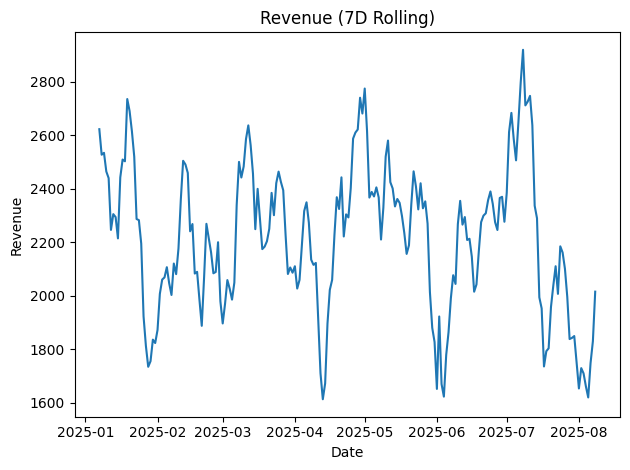

In [3]:
Path('../deliverables/images').mkdir(parents=True, exist_ok=True)
rev=df.set_index('date')['revenue'].rolling(7).mean()
plt.figure()
plt.plot(rev.index,rev.values)
plt.title('Revenue (7D Rolling)')
plt.xlabel('Date')
plt.ylabel('Revenue')
plt.tight_layout()
plt.savefig('../deliverables/images/line_revenue_trend.png')
plt.show()

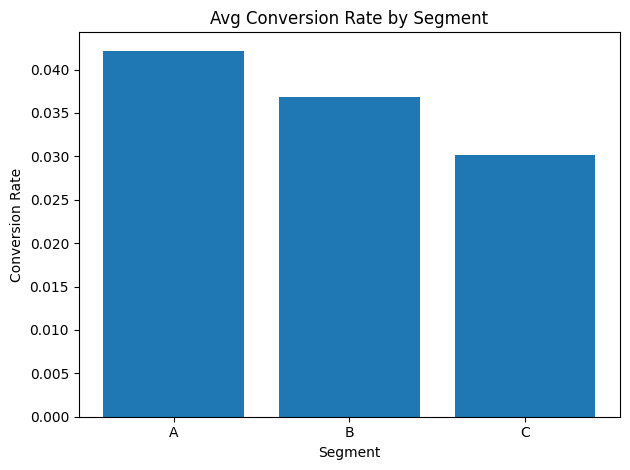

In [4]:
conv_by_seg=df.groupby('segment')['conversion_rate'].mean().reindex(['A','B','C'])
plt.figure()
plt.bar(conv_by_seg.index,conv_by_seg.values)
plt.title('Avg Conversion Rate by Segment')
plt.xlabel('Segment')
plt.ylabel('Conversion Rate')
plt.tight_layout()
plt.savefig('../deliverables/images/bar_conversion_by_segment.png')
plt.show()

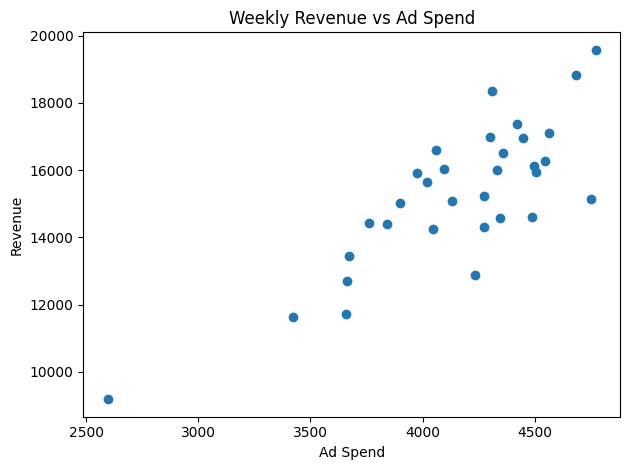

In [5]:
wk=df.resample('W-MON',on='date').agg({'ad_spend':'sum','revenue':'sum'}).reset_index()
plt.figure()
plt.scatter(wk['ad_spend'],wk['revenue'])
plt.title('Weekly Revenue vs Ad Spend')
plt.xlabel('Ad Spend')
plt.ylabel('Revenue')
plt.tight_layout()
plt.savefig('../deliverables/images/scatter_spend_vs_revenue.png')
plt.show()

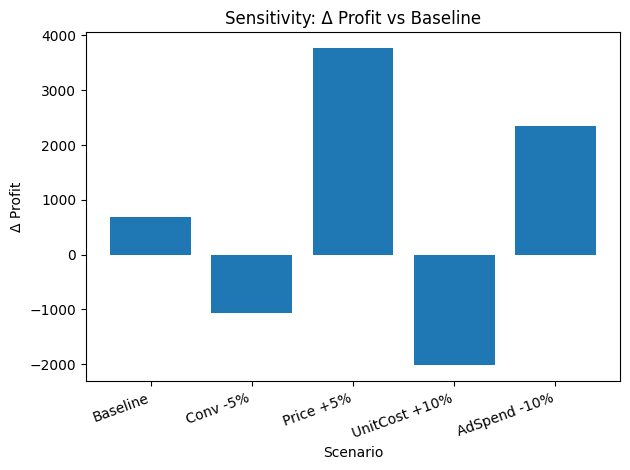

,scenario,avg_monthly_profit,delta_vs_baseline
0,Baseline,18164.274045,678.193647
1,Conv -5%,16425.188552,-1060.891847
2,Price +5%,21253.741232,3767.660834
3,UnitCost +10%,15463.510658,-2022.569741
4,AdSpend -10%,19826.017628,2339.937229


In [6]:
monthly=df.resample('MS',on='date').agg({'conversions':'sum','price':'mean','ad_spend':'sum','cogs':'sum','revenue':'sum'})
baseline=((monthly['revenue']-monthly['ad_spend']-monthly['cogs']).mean())
def scen(d,cm=1.0,pm=1.0,um=1.0,sm=1.0):
    m=d.copy()
    conv=m['conversions']*cm
    price=m['price']*pm
    rev=conv*price
    cogs=(conv*(m['cogs']/m['conversions'].replace(0,np.nan)).fillna(0))*um
    spend=m['ad_spend']*sm
    return (rev-spend-cogs).mean()
names=['Baseline','Conv -5%','Price +5%','UnitCost +10%','AdSpend -10%']
pars=[(1.0,1.0,1.0,1.0),(0.95,1.0,1.0,1.0),(1.0,1.05,1.0,1.0),(1.0,1.0,1.10,1.0),(1.0,1.0,1.0,0.90)]
vals=[scen(monthly,*t) for t in pars]
res=pd.DataFrame({'scenario':names,'avg_monthly_profit':vals})
res['delta_vs_baseline']=res['avg_monthly_profit']-baseline
res.to_csv('../deliverables/sensitivity_table.csv',index=False)
plt.figure()
plt.bar(res['scenario'],res['delta_vs_baseline'])
plt.title('Sensitivity: Δ Profit vs Baseline')
plt.xlabel('Scenario')
plt.ylabel('Δ Profit')
plt.xticks(rotation=20,ha='right')
plt.tight_layout()
plt.savefig('../deliverables/images/bar_sensitivity_delta_profit.png')
plt.show()
res